### Изучение нейронных сетей. Лаб.1

Установка ПО:

apt install ubuntu-drivers

ubuntu-drivers devices

ubuntu-drivers autoinstall

nvidia-smi

apt install nvidia-cuda-toolkit

curl -O https://repo.anaconda.com/archive/Anaconda3-2021.05-Linux-x86_64.sh

bash Anaconda3-2021.05-Linux-x86_64.sh -b

conda install pytorch torchvision cudatoolkit jupyter -y -c pytorch

jupyter notebook --no-browser --port=8080 --allow-root

ssh -L 8080:localhost:8080 dev@lab1

#### Проверка pytorch

In [2]:
from __future__ import print_function
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.6001, 0.8168, 0.2516],
        [0.4397, 0.4862, 0.3252],
        [0.2382, 0.5760, 0.4119],
        [0.2738, 0.4023, 0.8979],
        [0.1098, 0.4531, 0.6185]])


#### Проверка GPU. Разные варианты записи:

In [3]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    torch.cuda.current_device()
    torch.cuda.device(0)
    torch.cuda.device_count()
    torch.cuda.get_device_name(0)
else:
    device = torch.device("cpu")

/home/sbaykov/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


In [13]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GT 1030
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


Определим наше GPU как первое видимое устройство cuda.

In [2]:
# Assuming that we are on a CUDA machine, this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu" )
print(device)

cuda


#### Загрузка и нормализация CIFAR10. 

CIFAR - Canadian Institute For Andfanced Research. 

База содержит 60 тыс изображений в разрешении 3х32х32, разделенные на 10 классов.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

# Компонуемые преобразования для наборов данных
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Если изображения разные - добавляют преобразование, например transforms.Resize((32,32))
# Можно применить нормализацию по параметрам из ImageNet (mean & std)
# transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# mean - среднее отклонение
# std - стандартное отклонение

# mini-batches - мини-пакеты -
# batch_size=4 - размер пакета - сколько изображений пройдёт через сеть,
#                                прежде, чем мы обучим и обновим её

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)
# загрузчик

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, 
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Выведем несколько тренировочных образов для проверки:

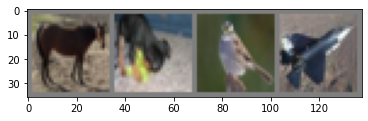

horse   dog  bird plane


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize - изменить в случае, 
    npimg = img.numpy()     # если использовались другие параметры нормализации!
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # см. permute, reshape для тензоров
    plt.show()

# get some random training images
dataiter = iter(trainloader)         # как работает итератор?
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))  
# 4 это количество изображений в пакете (размер мини-батча)

#### Определение нейронной сети.

Общее название - MLP - MultiLayer Perceptron.

В данном случае это Convolutional Neural Network - Свёрточная нейронная сеть.

Классическая схема:

![title](https://hsto.org/r/w1560/files/314/9c8/fcf/3149c8fcfa2146b6bf3b1115fd56deb6.png)

![title](https://hsto.org/r/w1560/webt/t8/4m/yg/t84mygi1sjuzssoezguistupmeo.png)

Convolutions - Свёртка

Subsampling - Подвыборка

Gaussian connections - соединения Гаусса–Манина

Сеть имеет 6 слоёв:
1. Входной фильтр. С1:feature maps 6@28x28
2. S2: feature maps 6@14x14
3. C3: feature maps 16@10x10
4. S4: feature maps 16@5x5
5. Полносвязный слой - F5 - 120
6. Полносвязный слой - F6 - 84

Выход - 10

На выходе используется Функция активации (Передаточная функция). 

Часто используется Сигмоид (Многомерная логистическая функция) - softmax()

$y=F(s)=\frac{1}{1+e^{-a*s}}=\frac{1}{1+\exp(-a*s)}$

<img src="https://taewanmerepo.github.io/2017/09/sigmoid/post.jpg" width="400">

А также Линейную выпрямительную функцию активации (ReLU)
<img src="https://i.stack.imgur.com/1BX7l.png">


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # Конструктор суперкласса
        
        # Описание слоёв:
        self.conv1 = nn.Conv2d(3, 6, 5)       #
        self.pool = nn.MaxPool2d(2, 2)        #
        self.conv2 = nn.Conv2d(6, 16, 5)      #
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # Полносвязный слой первый аргумент — определение 
                                              # количества узлов в i-том слое, а второй — 
                                              # количество узлов в i+1 слое
        self.fc2 = nn.Linear(120, 84)         # Полносвязный слой
        self.fc3 = nn.Linear(84, 10)          # Полносвязный слой

    # Функция, описывающая поток данных при обучении и предсказании
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)    # Преобразование в одномерный тензор
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

#### Определим функцию потерь и оптимизатор 

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # Функция потерь. 
#Есть альтернативный вариант MSELoss

# Оптимизатор SGD - Стохастический градиентный оптимизатор. 
# Есть альтернативные варианты: AdaGrad, RMSProp, Adam
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
# lr=0.001 - скорость обучения. Нужно подбирать!

#### Тренировка сети на тренировочных данных

In [9]:
# %%time
# %%prun

import time
start_time = time.time()

# Эпохи - 
# mini-batches - мини-пакеты -


for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):    # мини-батчи ?
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        # обнуление градиентов, вычисленных для предыдущего пакета
        optimizer.zero_grad()    

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()         # вычисляем градиенты
        optimizer.step()        # корректировка весов

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches - как считается?
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    print(i)
print('Finished Training')

print("Working time: %s seconds" % (time.time() - start_time))

[1,  2000] loss: 2.247
[1,  4000] loss: 1.892
[1,  6000] loss: 1.671
[1,  8000] loss: 1.588
[1, 10000] loss: 1.530
[1, 12000] loss: 1.472
12499
[2,  2000] loss: 1.390
[2,  4000] loss: 1.368
[2,  6000] loss: 1.340
[2,  8000] loss: 1.319
[2, 10000] loss: 1.288
[2, 12000] loss: 1.271
12499
Finished Training
Working time: 67.92948794364929 seconds
 CPU times: user 4min 24s, sys: 5.66 s, total: 4min 30s
Wall time: 1min 7s


In [ ]:
Без профайлера время выполнения:
    Working time: 60.50507616996765 seconds
С профайлером:
    Working time: 68.91293144226074 seconds
Первые строчки профайлера:
         24453957 function calls (24278954 primitive calls) in 68.699 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    25000   18.771    0.001   18.771    0.001 {method 'run_backward' of 'torch._C._EngineBase' objects}
    50000    6.919    0.000    6.919    0.000 {built-in method conv2d}
   350000    3.124    0.000    3.124    0.000 {built-in method posix.read}
   250000    2.077    0.000    2.077    0.000 {method 'mul_' of 'torch._C._TensorBase' objects}
    75000    1.863    0.000    1.863    0.000 {built-in method torch._C._nn.linear}
   500000    1.675    0.000    1.675    0.000 {method 'add_' of 'torch._C._TensorBase' objects}

#### Сохраняем нашу обученную модель:

In [38]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### Тестирование сети на тестовых данных. 

Часто используется подход: обучение -> валидация -> тестирование. И соответствующие наборы данных.

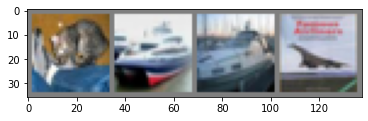

GroundTruth:    cat  ship  ship plane


In [39]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Теперь попросим нейронную сеть сообщить нам что на этих картинках:

In [40]:
net = Net()

# Загрузка параметров модели из файла
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)    # что значит _,  ?

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


Predicted:    cat  ship plane plane


#### Посмотрим, как сеть работает на всем наборе данных.

In [41]:
correct = 0
total = 0
with torch.no_grad():   # что значит no_grad() ?
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 64 %


#### Теперь посмотрим, какие классы сеть определяет лучше:

In [42]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 71 %
Accuracy of   car : 77 %
Accuracy of  bird : 49 %
Accuracy of   cat : 47 %
Accuracy of  deer : 60 %
Accuracy of   dog : 46 %
Accuracy of  frog : 72 %
Accuracy of horse : 66 %
Accuracy of  ship : 76 %
Accuracy of truck : 73 %


#### Отправляем сеть на GPU:

In [7]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Также нам придется отправлять входы и цели на каждом шаге и в GPU:

inputs, labels = data[0].to(device), data[1].to(device)

#### Запустим повторное обучение сети уже на GPU: 

In [11]:
# %%time
# %%prun

import time
start_time = time.time()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

print("Working time: %s seconds" % (time.time() - start_time))

[1,  2000] loss: 1.028
[1,  4000] loss: 1.032
[1,  6000] loss: 1.056
[1,  8000] loss: 1.056
[1, 10000] loss: 1.076
[1, 12000] loss: 1.055
[2,  2000] loss: 0.969
[2,  4000] loss: 0.985
[2,  6000] loss: 0.998
[2,  8000] loss: 1.004
[2, 10000] loss: 1.013
[2, 12000] loss: 1.013
Finished Training
Working time: 56.64906024932861 seconds


In [ ]:
Без профайлера время выполнения:
    Working time: 58.505470275878906 seconds
С профайлером:
    Working time: 64.53588533401489 seconds
Первые строчки профайлера:
 24504260 function calls (24329246 primitive calls) in 64.327 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    25000   15.599    0.001   15.599    0.001 {method 'run_backward' of 'torch._C._EngineBase' objects}
    50000    3.282    0.000    3.282    0.000 {built-in method conv2d}
   350000    3.086    0.000    3.086    0.000 {built-in method posix.read}
   499990    2.903    0.000    2.903    0.000 {method 'add_' of 'torch._C._TensorBase' objects}
    75000    2.425    0.000    2.425    0.000 {built-in method torch._C._nn.linear}
   249990    2.284    0.000    2.284    0.000 {method 'mul_' of 'torch._C._TensorBase' objects}
    50000    1.869    0.000    1.869    0.000 {method 'to' of 'torch._C._TensorBase' objects}
   100000    1.851    0.000    1.851    0.000 {built-in method relu}

#### Проверка использования видеопамяти

In [19]:
!nvidia-smi

Mon Oct  4 11:15:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:20:00.0  On |                  N/A |
| 36%   37C    P0    N/A /  30W |    660MiB /  1998MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
torch.cuda.empty_cache()